In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import sys
sys.path.append('../mchem_functions')
import PCA_functions as pcf
import multivariate_functions as mvf

In [2]:
chosen_PCs = [1,2]
no_of_components = 5

scaling_method = 'SNV'

nmr_data_dir = '../../Data/NMR'
nmr_spectra_dir = 'txt_spectra'
nmr_data_arc = 'nmr_archive'

replicate_filter = 1

In [3]:
try: os.chdir(nmr_data_dir)
except FileNotFoundError: pass

In [4]:
siteslong = {
    'HM': 'Hare Moss',
    'AM': 'Auchencorth Moss'
}

def wetordry(str):
    if str in ([f'HM-{x}' for x in ['A','B','C','D']] + [f'AM-{x}' for x in ['A','B']]):
        return 'dry'
    else: return 'wet'

def get_attr(s:str):
    s = s.replace('MP-','').replace('PW-','')
    # sample_name = s
    s = s.split('-')
    sample_name = '-'.join(s[:-1])
    site = s[0]
    sitelong = siteslong[site]
    season = s[-2]
    replicate = s[-1]
    wet = wetordry('-'.join(s[:-2]))

    return sample_name,site,sitelong,season,replicate,wet

m_shape = {
    'Hare Moss': 'o',
    'Auchencorth Moss': 's',
}

seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win1': '#4B61D1', # Savoy blue
    'Win2': '#4E2A84', # northwestern purple
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

wetordry_colours = {
    'dry': 'orange',
    'wet': 'blue'
}
wetordry_markers = {
    'dry': 'D',
    'wet': 'P'
}

In [5]:
path = f"{nmr_data_arc}\\*\\11\\pdata\\*\\integrals.txt"
integral_files = glob.glob(path)
integrals_list = []
attribute_list = []

for file in integral_files:

    # make sure all -'s are separated with at least one space
    with open(file, 'r') as f:
        filedata = f.read()
    filedata = filedata.replace('-', ' -')
    with open(file, 'w') as f:
        f.write(filedata)
    f.close()

    int_df = pd.read_csv(file,skiprows=4,sep=r"\s+")
    integrals_list.append(int_df['Integral'].to_numpy())
    attribute_list.append([*get_attr(file.split('\\')[1])])

    if len(integrals_list[-1]) == 0:
        print(attribute_list[-1])

ppm = np.mean(int_df[['Integrated','Region']].to_numpy(),axis=1)

attribute_array = np.array(attribute_list)
integrals_arr = np.array(integrals_list)
no_of_spectra = len(integrals_arr)
names_unique = np.unique(attribute_array[:,0])

In [6]:
# replicate filter
if replicate_filter:
    integrals_arr = integrals_arr[[np.argmax(attribute_array[:,0]==x) for x in names_unique]]
    attribute_array = attribute_array[[np.argmax(attribute_array[:,0]==x) for x in names_unique]]
    no_of_spectra = len(integrals_arr)

In [7]:
row_sum = np.sum(integrals_arr,axis=1)
integrals_arr = integrals_arr / np.reshape(row_sum,(len(row_sum),1))

(9.995000000000001, -0.095)

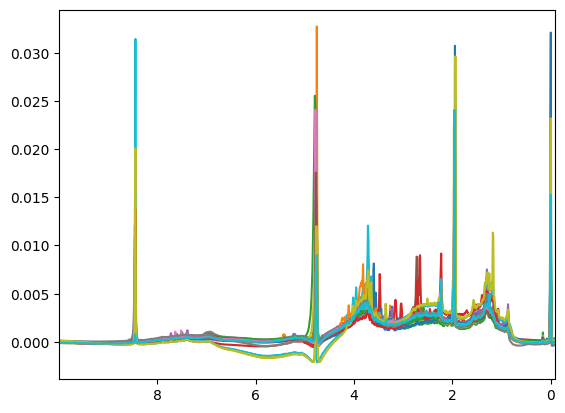

In [8]:
fig_unproc,ax_unproc = plt.subplots()
for i in range(no_of_spectra):
    ax_unproc.plot(ppm,integrals_arr[i,:])

ax_unproc.set_xlim(np.max(ppm),np.min(ppm))

In [9]:
ppm

array([ 9.995,  9.985,  9.975, ..., -0.075, -0.085, -0.095])

In [10]:
# set regions to exclude and exclude them
regions_to_exclude = [[np.min(ppm),0.3],
                      [1.92,2],
                      [4.5,5], #[4.5,5.07]             
                      [10,np.max(ppm)]] # 8.2,10

idx_to_exclude = []
for r in regions_to_exclude:
    idx_to_exclude += [*np.where((ppm>=np.min(r))&(ppm<=np.max(r)))[0]]
idx_to_include = np.array([x for x in np.arange(len(ppm)) if x not in idx_to_exclude])
ppm = ppm[idx_to_include]
integrals_arr = integrals_arr[:,idx_to_include]

In [11]:
def broken_plot(axes,x,y,cuts):
    for ax in axes:
        for i in range(len(y)):
            ax.plot(x,y[i,:])
        
        if ax == axes[0]:
            ax.spines['right'].set_visible(False)

        elif ax != axes[-1]:
            ax.tick_params(labelright='off',labelleft='off')
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.tick_params(labelright='off')
            ax.set_yticks([])
            ax.yaxis.set_tick_params(labelleft=False,labelright=False)

        else:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_tick_params(labelleft=False)
            ax.set_yticks([])

    for i in range(len(axes)):

        xlim = [cuts[i+1][0],cuts[i][1]]
        print(xlim)

        xticks = np.linspace(np.min(xlim),np.max(xlim),3)#list(range(0,10,2))+list(xlim)
        xticks.sort()

        axes[np.arange(len(axes))[::-1][i]].set_xticks(xticks)
        axes[np.arange(len(axes))[::-1][i]].set_xlim(xlim)

[1.92, 0.3]
[4.5, 2]
[10, 5]


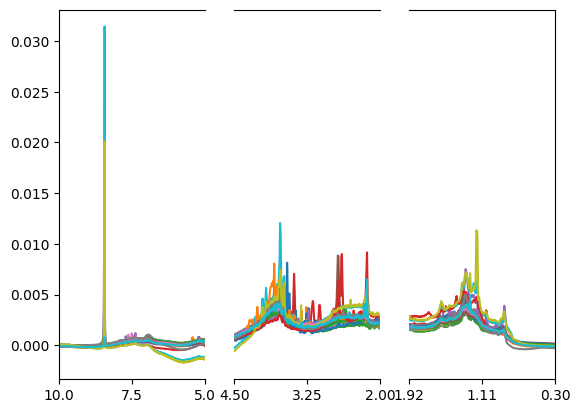

In [12]:
fig_unproc,ax_unproc = plt.subplots(1,len(regions_to_exclude)-1)
broken_plot(ax_unproc,ppm,integrals_arr,regions_to_exclude)

[1.92, 0.3]
[4.5, 2]
[10, 5]


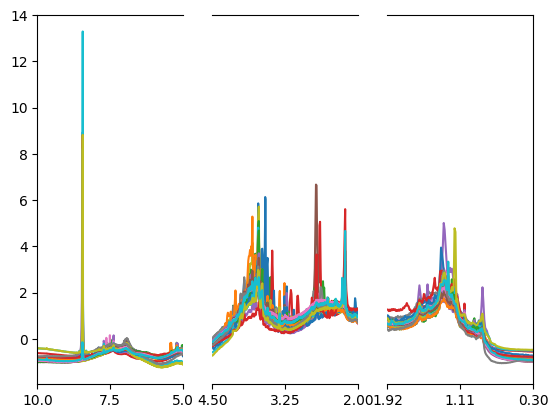

In [13]:
fig_snv,ax_snv = plt.subplots(1,len(regions_to_exclude)-1)
snv = mvf.SNV(integrals_arr)

broken_plot(ax_snv,ppm,snv,regions_to_exclude)

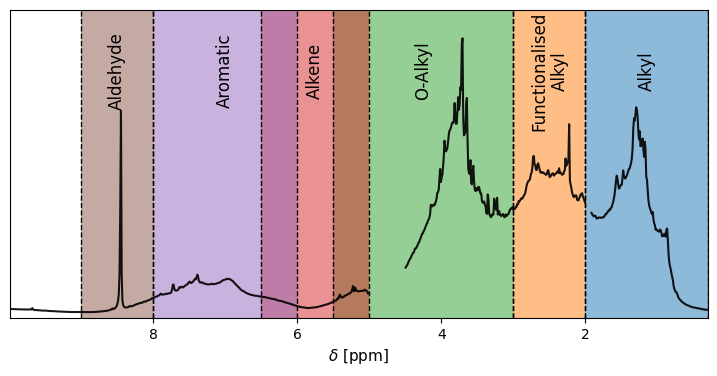

In [14]:
avg = np.mean(snv,axis=0)

ppm_for_plot = ppm.copy()

for r in regions_to_exclude:
    if np.min(r) < np.max(ppm) and np.max(r) > np.min(ppm):
        argmax = np.argmax(ppm<=np.min(r))
        excl_idx = [argmax,argmax-1]
        avg = np.insert(avg,argmax,np.nan)
        ppm_for_plot = np.insert(ppm_for_plot,argmax,np.min(r))

fig_avg,ax_avg = plt.subplots(figsize=(9,4))
ax_avg.plot(ppm_for_plot,avg,c='k',alpha=.9)
ax_avg.set_xlim(np.max(ppm),np.min(ppm))
ax_avg.set_title('',fontsize=18)
ax_avg.set_xlabel('$\\delta$ [ppm]',fontsize=11)
ax_avg.set_yticks([])

# region_boundaries = [2,3,5.5,6.5]
regions = {'Alkyl':[np.min(ppm),2],
           'Functionalised\nAlkyl':[2,3],
           'O-Alkyl':[3,5.5],
           'Alkene':[5,6.5],
           'Aromatic':[6,8],
           'Aldehyde':[8,9],
           }

reg_y = np.max(ax_avg.get_ylim()) * .8
ax_avg.set_ylim(-1,4)
for r in regions:

    x = ((np.max(regions[r])+np.min(regions[r])) / 2)

    ax_avg.text(x,reg_y,r,ha='center',va='center',
                fontsize=12,rotation=90)

    ax_avg.axvline(x=np.min(regions[r]), color = '#000', linestyle = '--', linewidth = 1)
    ax_avg.axvline(x=np.max(regions[r]), color = '#000', linestyle = '--', linewidth = 1)

    ax_avg.fill_between(regions[r],-1,4,
                        alpha=.5)

fig_avg.savefig(f'plots/avg_nmr_spectrum.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

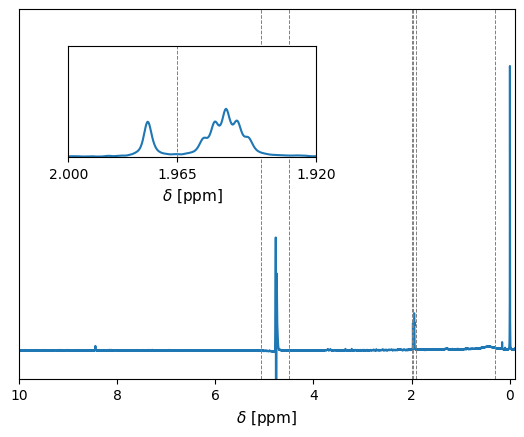

In [15]:
buffer_file = 'buffer_spectra/buffer2-2025-01-23.txt'

buff_int = pd.read_csv(buffer_file,skiprows=9)['#'].to_numpy()
buff_int = buff_int / np.max(buff_int)
buff_ppms = np.linspace(24.76679039001465,-15.24729686767541,131072)

cutouts = [0.3,-0.1,1.965,1.92,2,5.07,4.5]

fig_buff,ax_buff = plt.subplots()
ax_buff.plot(buff_ppms,buff_int)
ax_buff.set_xlim(10,-.1)
ax_buff.set_ylim(-.1,1.2)

ax_buff.set_yticklabels([])
ax_buff.set_yticks([])

ax_buff.set_title('',fontsize=16)
ax_buff.set_xlabel('$\\delta$ [ppm]',fontsize=11)

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/zoom_inset_axes.html
x1, x2, y1, y2 = 2,1.92,0,.3  # subregion of the original image
axins = ax_buff.inset_axes(
    [.1, 0.6, 0.5, 0.3],
    xlim=(x1, x2), ylim=(y1, y2),yticklabels=[],yticks=[],xticks=[2,1.965,1.92])
axins.plot(buff_ppms,buff_int)

axins.set_xlabel('$\\delta$ [ppm]',fontsize=11)

for x in cutouts:
    axins.axvline(x,ls='--',c='gray',lw=.7)
    ax_buff.axvline(x,ls='--',c='gray',lw=.7)

# ax_buff.indicate_inset_zoom(axins, edgecolor="black")

# labels = {
#     'Acetate': [buff_ppms[np.where((buff_ppms<2)&(buff_ppms>1.965))][np.where(buff_int[np.where((buff_ppms<2)&(buff_ppms>1.965))]==np.max(buff_int[np.where((buff_ppms<2)&(buff_ppms>1.965))]))],
#                 np.max(buff_int[np.where((buff_ppms<2)&(buff_ppms>1.965))])],
#     # 'Acetate-$d2$': [buff_ppms[np.where((buff_ppms<2)&(buff_ppms>1.965))][np.where(buff_int[np.where((buff_ppms<2)&(buff_ppms>1.965))]==np.max(buff_int[np.where((buff_ppms<2)&(buff_ppms>1.965))]))],
#     #             np.max(buff_int[np.where((buff_ppms<2)&(buff_ppms>1.965))])]
# }

# for l in labels:
#     axins.scatter(*labels[l],marker='|',c='tab:orange',zorder=2)
#     axins.text(*labels[l],s=l,c='tab:orange',zorder=2,rotation=-45,ha='right',va='baseline')

fig_buff.savefig(f'plots/buffer.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

In [16]:
buff_ppms

array([ 24.76679039,  24.7664851 ,  24.76617982, ..., -15.2466863 ,
       -15.24699158, -15.24729687])

Aut mean intensity: 3.3347191292270475
Win1 mean intensity: 4.4713367956356995
Win2 mean intensity: -0.218886931034321


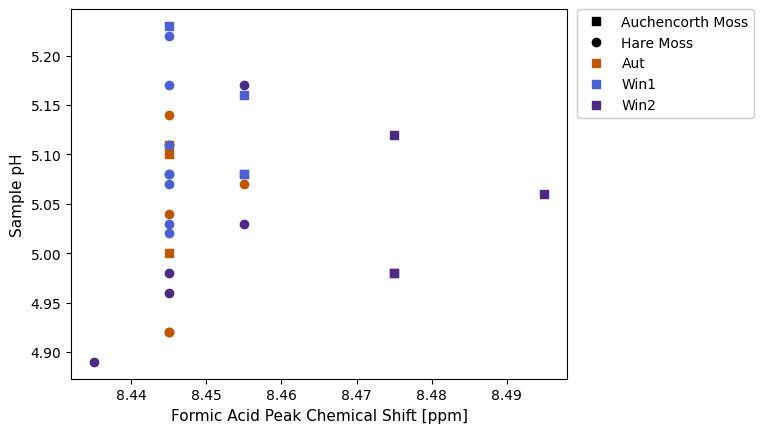

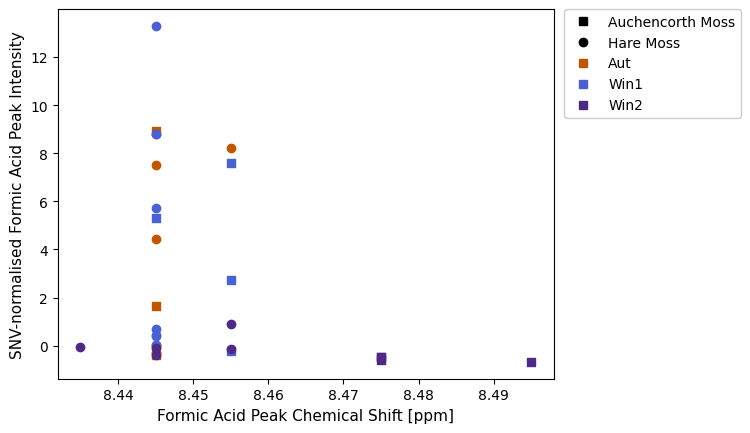

In [17]:
ppm_thresh = 8.2
if np.max(ppm)>ppm_thresh:

    fig_pH, ax_pH = plt.subplots()
    fig_pH_int, ax_pH_int = plt.subplots()

    pH_df = pd.read_csv('pH.csv')
    pH_arr = pH_df['pH'].to_numpy()

    form_ac_idx = np.argmax(snv[:,np.where(ppm>ppm_thresh)[0]],axis=1)
    form_ac_ppm = ppm[form_ac_idx]
    form_ac_snv = np.max(snv[:,np.where(ppm>ppm_thresh)[0]],axis=1)

    for site in np.unique(attribute_array[:,2]):
        for season in np.unique(attribute_array[:,3]):

            idx = np.where((attribute_array[:,2] == site)&(attribute_array[:,3] == season))
            ax_pH.scatter(form_ac_ppm[idx],pH_arr[idx],marker=m_shape[site],c=seasonal_colours[season])
            ax_pH_int.scatter(form_ac_ppm[idx],form_ac_snv[idx],marker=m_shape[site],c=seasonal_colours[season])

    ax_pH.set_xlabel('Formic Acid Peak Chemical Shift [ppm]',fontsize=11)
    ax_pH.set_ylabel('Sample pH',fontsize=11)

    ax_pH_int.set_xlabel('Formic Acid Peak Chemical Shift [ppm]',fontsize=11)
    ax_pH_int.set_ylabel('SNV-normalised Formic Acid Peak Intensity',fontsize=11)

    f = lambda m,c,ls: ax_pH.plot([],[],marker=m, color=c, ls=ls)[0]
    handles = []
    labels  = []
    for site in np.unique(attribute_array[:,2]):
        handles.append(f(m_shape[site], "k", ls="none"))
        labels.append(site)
    for season in np.unique(attribute_array[:,3]):
        handles.append(f('s', seasonal_colours[season],ls="none"))
        labels.append(season)

    ax_pH.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax_pH_int.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    ax_pH.set_title('',fontsize=16)
    ax_pH_int.set_title('',fontsize=16)

    fig_pH.savefig(f'plots/pH_vs_formicacid.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')
    fig_pH_int.savefig(f'plots/formicacid_intvsppm.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

    np.median(form_ac_ppm),np.min(form_ac_ppm),np.max(form_ac_ppm)
    for season in np.unique(attribute_array[:,3]):
        print(f'{season} mean intensity: {np.mean(form_ac_snv[np.where(attribute_array[:,3] == season)])}')

In [18]:
no_of_pcs = 5
scores_values, variance_ratio, PCs, loadings = pcf.get_pca_data(snv,method=None,no_of_components=no_of_pcs)

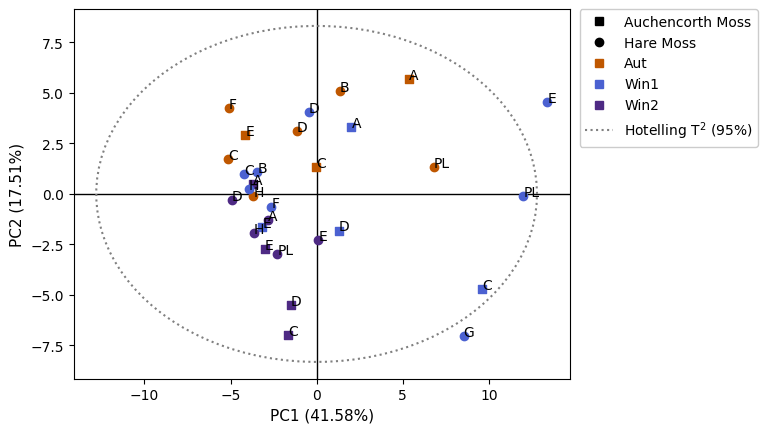

In [19]:
fig_scores, ax_scores = plt.subplots()

for site in np.unique(attribute_array[:,2]):
    for season in np.unique(attribute_array[:,3]):

        idx = np.where((attribute_array[:,2] == site)&(attribute_array[:,3] == season))

        pcf.scores_plot(scores_values[idx],chosen_PCs,lines=False,ax=ax_scores,marker=m_shape[site],c=seasonal_colours[season],
                        variance_ratio=variance_ratio)

       
pcf.Hotelling(scores_values,chosen_PCs,ax_scores)

title = f' Scores Plot of the NMR Data by Site and Season'
ax_scores.set_title('',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

# Adapted from https://stackoverflow.com/questions/45140295/how-to-create-a-legend-of-both-color-and-marker
f = lambda m,c,ls: ax_scores.plot([],[],marker=m, color=c, ls=ls)[0]
handles = []
labels  = []
for site in np.unique(attribute_array[:,2]):
    handles.append(f(m_shape[site], "k", ls="none"))
    labels.append(site)
for season in np.unique(attribute_array[:,3]):
    handles.append(f('s', seasonal_colours[season],ls="none"))
    labels.append(season)

handles += [f('none', "grey",ls=":")]
labels += ['Hotelling T$^{2}$ (95%)']
ax_scores.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig_scores.savefig(f'plots/nmr_pca_scores.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

for i in range(no_of_spectra):
    ax_scores.text(scores_values[i,chosen_PCs[0]-1],scores_values[i,chosen_PCs[1]-1],attribute_array[i,0].split('-')[1])

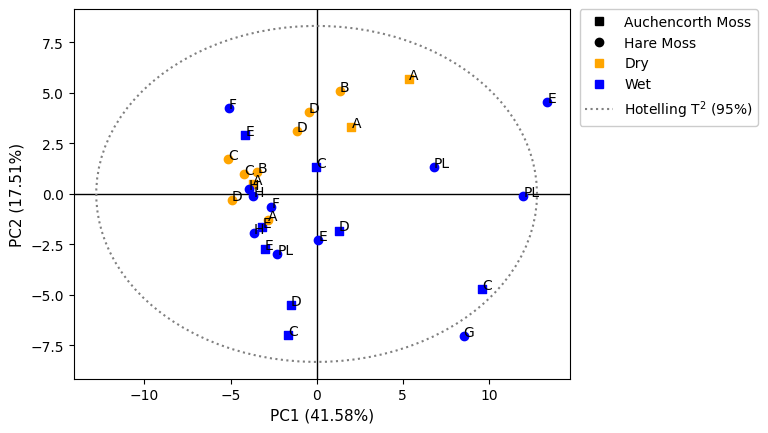

In [20]:
fig_scores, ax_scores = plt.subplots()

for site in np.unique(attribute_array[:,2]):
    for hum in np.unique(attribute_array[:,5]):

        idx = np.where((attribute_array[:,2] == site)&(attribute_array[:,5] == hum))

        pcf.scores_plot(scores_values[idx],chosen_PCs,lines=False,ax=ax_scores,marker=m_shape[site],
                        c=wetordry_colours[hum],variance_ratio=variance_ratio)
       
pcf.Hotelling(scores_values,chosen_PCs,ax_scores)

title = f'Scores Plot of the NMR Data by Site and Wetness'
ax_scores.set_title('',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

# Adapted from https://stackoverflow.com/questions/45140295/how-to-create-a-legend-of-both-color-and-marker
f = lambda m,c,ls: ax_scores.plot([],[],marker=m, color=c, ls=ls)[0]
handles = []
labels  = []
for site in np.unique(attribute_array[:,2]):
    handles.append(f(m_shape[site], "k", ls="none"))
    labels.append(site)
for hum in np.unique(attribute_array[:,5]):
    handles.append(f('s', wetordry_colours[hum],ls="none"))
    labels.append(hum.capitalize())

handles += [f('none', "grey",ls=":")]
labels += ['Hotelling T$^{2}$ (95%)']
ax_scores.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig_scores.savefig(f'plots/nmr_pca_scores_wetness.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

for i in range(no_of_spectra):
    ax_scores.text(scores_values[i,chosen_PCs[0]-1],scores_values[i,chosen_PCs[1]-1],attribute_array[i,0].split('-')[1])

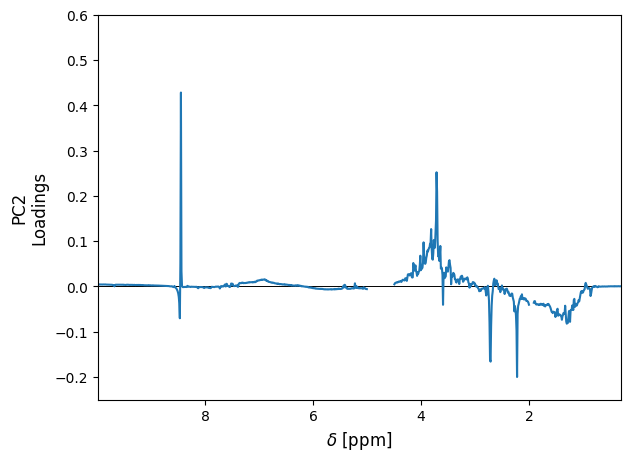

In [21]:
loadings_for_plot = loadings.copy()
ppm_for_plot = ppm.copy()

loadings_chosen_PCs = [2]

for r in regions_to_exclude:
    if np.min(r) < np.max(ppm) and np.max(r) > np.min(ppm):
        argmax = np.argmax(ppm<=np.min(r))
        excl_idx = [argmax,argmax-1]
        loadings_for_plot = np.insert(loadings_for_plot,argmax,np.nan,axis=1)
        ppm_for_plot = np.insert(ppm_for_plot,argmax,np.min(r))

fig_loadings = plt.figure(figsize=(6.75,5))
ax_loadings = fig_loadings.subplots(len(loadings_chosen_PCs),sharex=True)

# fig_loadings.suptitle('',fontsize=16)

ax_loadings.set_xlim(np.max(ppm),np.min(ppm))
ax_loadings.set_ylim(-.25,.6)

# for i in range(len(loadings_chosen_PCs)):
#     ax_loadings[i].axhline(y=0, color = '#000', linewidth = 0.7)
#     ax_loadings[i].plot(ppm_for_plot,loadings_for_plot[loadings_chosen_PCs[i]-1,:])
#     ax_loadings[i].set_ylabel(f'PC{loadings_chosen_PCs[i]}\nLoadings',fontsize=12)

ax_loadings.axhline(y=0, color = '#000', linewidth = 0.7)
ax_loadings.plot(ppm_for_plot,loadings_for_plot[loadings_chosen_PCs[0]-1,:])
ax_loadings.set_ylabel(f'PC{loadings_chosen_PCs[0]}\nLoadings',fontsize=12)

ax_loadings.set_xlabel('$\\delta$ [ppm]',fontsize=12)

fig_loadings.savefig(f'plots/loadings_plots.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

In [22]:
ppm[np.where(loadings[0,:]==np.min(loadings[0,:]))],ppm[np.where(loadings[0,:]==np.max(loadings[0,:]))]

(array([3.815]), array([8.445]))

In [23]:
interval = [2,3]
height = 0.1
interval_idx = np.where((ppm>np.min(interval))&(ppm<np.max(interval)))
print(ppm[interval_idx][find_peaks(np.abs(loadings[loadings_chosen_PCs[0]-1,:][interval_idx]),height=height)[0]],
      loadings[loadings_chosen_PCs[0]-1,:][interval_idx][find_peaks(np.abs(loadings[loadings_chosen_PCs[0]-1,:][interval_idx]),height=height)[0]])

[2.715 2.225] [-0.16584708 -0.19984948]


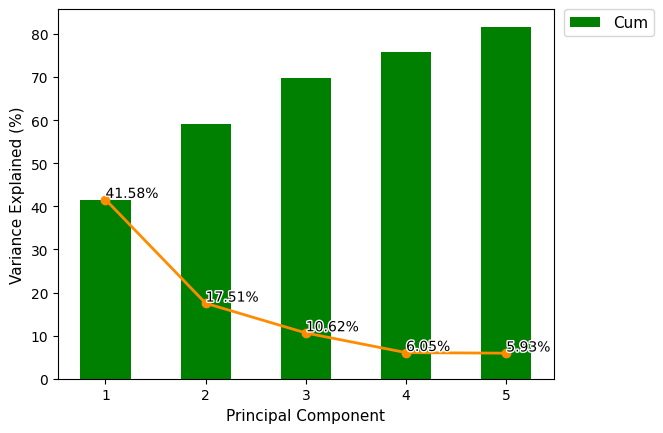

In [24]:
pcf.scree_plot(PCs,variance_ratio,save_path=f'plots/scree_plot.svg',title='')

In [25]:
scores_values_HM, variance_ratio_HM, PCs_HM, loadings_HM = pcf.get_pca_data(snv[np.where(attribute_array[:,1]=='HM')[0]],method=None)
scores_values_AM, variance_ratio_AM, PCs_AM, loadings_AM = pcf.get_pca_data(snv[np.where(attribute_array[:,1]=='AM')[0]],method=None)

In [26]:
attribute_array[:,5]

array(['dry', 'dry', 'dry', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet',
       'wet', 'wet', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry',
       'dry', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet',
       'wet', 'wet', 'wet'], dtype='<U16')

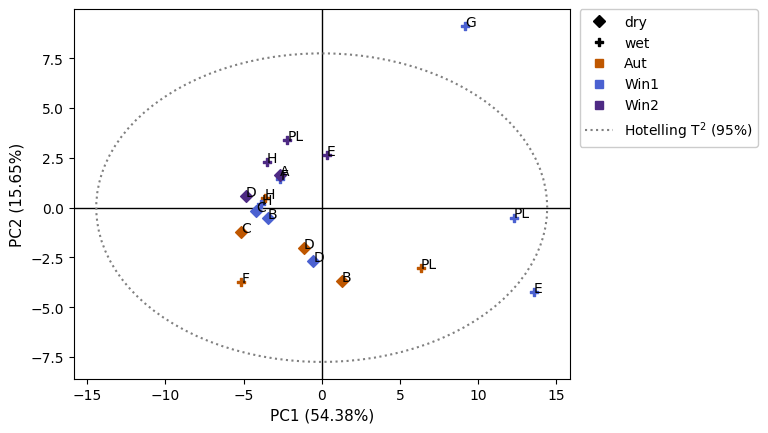

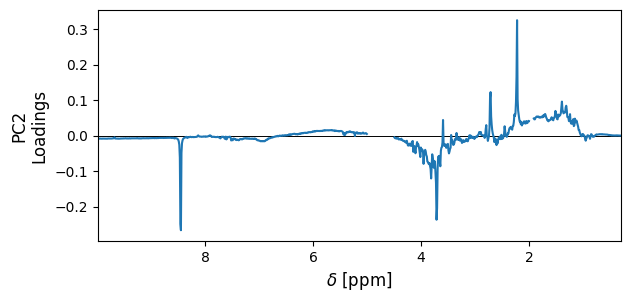

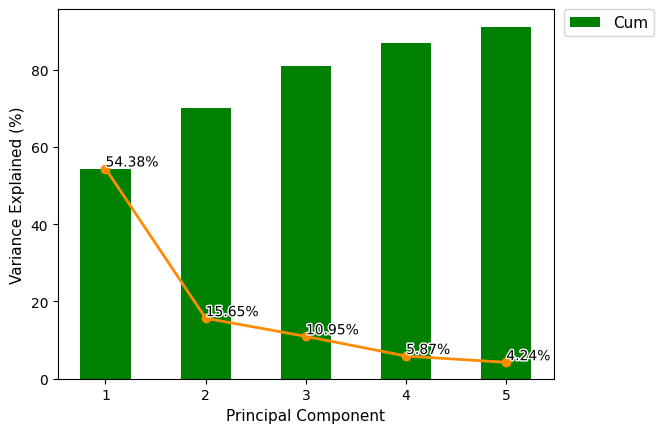

In [ ]:
fig_scores_HM, ax_scores_HM = plt.subplots()

for season in np.unique(attribute_array[:,3]):
    for wor in np.unique(attribute_array[:,5]):

        idx = np.where((attribute_array[np.where(attribute_array[:,1]=='HM')][:,3] == season)&
                       (attribute_array[np.where(attribute_array[:,1]=='HM')][:,5] == wor))

        pcf.scores_plot(scores_values_HM[idx],chosen_PCs,lines=False,ax=ax_scores_HM,
                        c=seasonal_colours[season],marker=wetordry_markers[wor],
                        label=season,variance_ratio=variance_ratio_HM)

pcf.Hotelling(scores_values_HM,chosen_PCs,ax_scores_HM)

title = '$^{1}$H NMR PCA Scores of Hare Moss by Season'
ax_scores_HM.set_title('',fontsize=15)
ax_scores_HM.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores_HM.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

f = lambda m,c,ls: ax_scores.plot([],[],marker=m, color=c, ls=ls)[0]
handles = []
labels  = []
for wor in np.unique(attribute_array[:,5]):
    handles.append(f(wetordry_markers[wor], "k", ls="none"))
    labels.append(wor)
for season in np.unique(attribute_array[:,3]):
    handles.append(f('s', seasonal_colours[season],ls="none"))
    labels.append(season)

handles += [f('none', "grey",ls=":")]
labels += ['Hotelling T$^{2}$ (95%)']
ax_scores_HM.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig_scores_HM.savefig(f'plots/hm_nmr_pca_scores.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

for i in range(len(scores_values_HM)):
    ax_scores_HM.text(scores_values_HM[i,chosen_PCs[0]-1],scores_values_HM[i,chosen_PCs[1]-1],attribute_array[np.where(attribute_array[:,1]=='HM')][i,0].split('-')[1])

#---
loadings_HM_for_plot = loadings_HM.copy()

for r in regions_to_exclude:
    if np.min(r) < np.max(ppm) and np.max(r) > np.min(ppm):
        argmax = np.argmax(ppm<=np.min(r))
        loadings_HM_for_plot = np.insert(loadings_HM_for_plot,argmax,np.nan,axis=1)

fig_loadings_HM = plt.figure(figsize=(6.75,3))
ax_loadings_HM = fig_loadings_HM.subplots(len(loadings_chosen_PCs),sharex=True)

fig_loadings_HM.suptitle('',fontsize=16)
ax_loadings_HM.set_xlim(np.max(ppm),np.min(ppm))

ax_loadings_HM.axhline(y=0, color = '#000', linewidth = 0.7)
ax_loadings_HM.plot(ppm_for_plot,loadings_HM_for_plot[loadings_chosen_PCs[0]-1,:])
ax_loadings_HM.set_ylabel(f'PC{loadings_chosen_PCs[0]}\nLoadings',fontsize=12)

ax_loadings_HM.set_xlabel('$\\delta$ [ppm]',fontsize=12)

fig_loadings_HM.savefig(f'plots/loadings_HM_plots.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

#---
pcf.scree_plot(range(1,np.min([len(PCs_HM),no_of_pcs])+1),variance_ratio_HM,save_path=f'plots/hm_scree_plot.svg',title='')

In [28]:
interval = [2,3]
height = 0.15
interval_idx = np.where((ppm>np.min(interval))&(ppm<np.max(interval)))
print(ppm[interval_idx][find_peaks(np.abs(loadings_HM[loadings_chosen_PCs[0]-1,:][interval_idx]),height=height)[0]],
      loadings_HM[loadings_chosen_PCs[0]-1,:][interval_idx][find_peaks(np.abs(loadings_HM[loadings_chosen_PCs[0]-1,:][interval_idx]),height=height)[0]])

[2.225] [0.3255124]


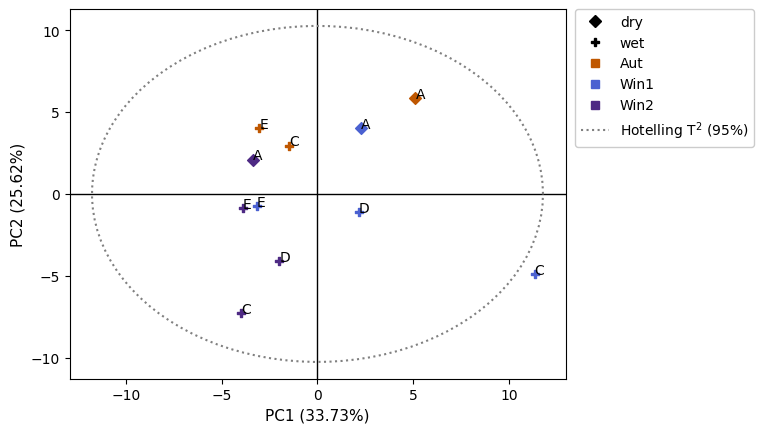

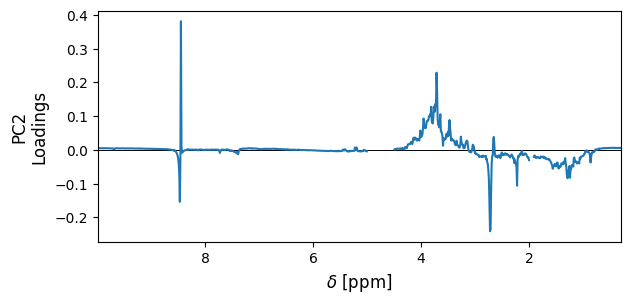

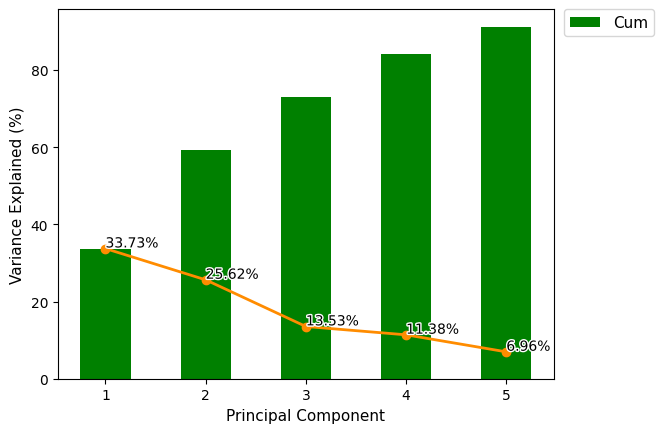

In [34]:
fig_scores_AM, ax_scores_AM = plt.subplots()

for season in np.unique(attribute_array[:,3]):
    for wor in np.unique(attribute_array[:,5]):

        idx = np.where((attribute_array[np.where(attribute_array[:,1]=='AM')][:,3] == season)&
                       (attribute_array[np.where(attribute_array[:,1]=='AM')][:,5] == wor))

        pcf.scores_plot(scores_values_AM[idx],chosen_PCs,lines=False,ax=ax_scores_AM,
                        c=seasonal_colours[season],marker=wetordry_markers[wor],
                        label=season,variance_ratio=variance_ratio_AM)

pcf.Hotelling(scores_values_AM,chosen_PCs,ax_scores_AM)

title = '$^{1}$H NMR PCA Scores of Auchencorth Moss by Season'
ax_scores_AM.set_title('',fontsize=15)
ax_scores_AM.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores_AM.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

f = lambda m,c,ls: ax_scores.plot([],[],marker=m, color=c, ls=ls)[0]
handles = []
labels  = []
for wor in np.unique(attribute_array[:,5]):
    handles.append(f(wetordry_markers[wor], "k", ls="none"))
    labels.append(wor)
for season in np.unique(attribute_array[:,3]):
    handles.append(f('s', seasonal_colours[season],ls="none"))
    labels.append(season)

handles += [f('none', "grey",ls=":")]
labels += ['Hotelling T$^{2}$ (95%)']
ax_scores_AM.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig_scores_AM.savefig(f'plots/am_nmr_pca_scores.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

for i in range(len(scores_values_AM)):
    ax_scores_AM.text(scores_values_AM[i,chosen_PCs[0]-1],scores_values_AM[i,chosen_PCs[1]-1],attribute_array[np.where(attribute_array[:,1]=='AM')][i,0].split('-')[1])

#---
loadings_AM_for_plot = loadings_AM.copy()

for r in regions_to_exclude:
    if np.min(r) < np.max(ppm) and np.max(r) > np.min(ppm):
        argmax = np.argmax(ppm<=np.min(r))
        loadings_AM_for_plot = np.insert(loadings_AM_for_plot,argmax,np.nan,axis=1)

fig_loadings_AM = plt.figure(figsize=(6.75,3))
ax_loadings_AM = fig_loadings_AM.subplots(len(loadings_chosen_PCs),sharex=True)

fig_loadings_AM.suptitle('',fontsize=16)
ax_loadings_AM.set_xlim(np.max(ppm),np.min(ppm))

# for i in range(len(loadings_chosen_PCs)):
#     ax_loadings_AM[i].axhline(y=0, color = '#000', linewidth = 0.7)
#     ax_loadings_AM[i].plot(ppm_for_plot,loadings_AM_for_plot[loadings_chosen_PCs[0]-1,:])
#     ax_loadings_AM[i].set_ylabel(f'PC{loadings_chosen_PCs[i]}\nLoadings',fontsize=12)

ax_loadings_AM.set_xlabel('$\\delta$ [ppm]',fontsize=12)

ax_loadings_AM.axhline(y=0, color = '#000', linewidth = 0.7)
ax_loadings_AM.plot(ppm_for_plot,loadings_AM_for_plot[loadings_chosen_PCs[0]-1,:])
ax_loadings_AM.set_ylabel(f'PC{loadings_chosen_PCs[0]}\nLoadings',fontsize=12)

fig_loadings_AM.savefig(f'plots/loadings_AM_plots.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

#---
pcf.scree_plot(range(1,np.min([len(PCs_AM),no_of_pcs])+1),variance_ratio_AM,save_path=f'plots/am_scree_plot.svg',title='')

In [30]:
ppm[np.where(loadings_AM[0,:]==np.min(loadings_AM[0,:]))],ppm[np.where(loadings_AM[0,:]==np.max(loadings_AM[0,:]))]

(array([2.725]), array([8.455]))

In [31]:
interval = [2,3]
height = 0.15
interval_idx = np.where((ppm>np.min(interval))&(ppm<np.max(interval)))
print(ppm[interval_idx][find_peaks(np.abs(loadings_AM[loadings_chosen_PCs[0]-1,:][interval_idx]),height=height)[0]],
      loadings_AM[loadings_chosen_PCs[0]-1,:][interval_idx][find_peaks(np.abs(loadings_AM[loadings_chosen_PCs[0]-1,:][interval_idx]),height=height)[0]])

[2.725] [-0.24125862]
